In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
%cd gdrive/My\ Drive/Thesis/source/stylegan-encoder
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

/content/gdrive/My Drive/Thesis/source/stylegan-encoder
TensorFlow 1.x selected.
1.15.2


In [0]:
import os
import pickle
import config
import dnnlib
import gzip
import json
import numpy as np
from tqdm import tqdm_notebook
import warnings
import matplotlib.pylab as plt
%matplotlib inline
warnings.filterwarnings("ignore")

# Loading data

In [0]:
# Thanks for Microsoft Cognitive Services API (free trial) for labeling of generated images
# https://azure.microsoft.com/en-us/services/cognitive-services/face/

# A pretty simple logic was used for generating images:

# qlatents = np.random.normal(size=(1, 512))
# dlatents = Gs_network.components.mapping.run(qlatents, None, minibatch_size=1, randomize_noise=False, structure='fixed') # untruncated by default, I guess
# images = Gs_network.components.synthesis.run(dlatents, minibatch_size=1, randomize_noise=False, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), structure='fixed')

# After that generated image was sent to Micriosft API and response was stored as is

In [3]:
LATENT_TRAINING_DATA = 'https://drive.google.com/uc?id=1xMM3AFq0r014IIhBLiMCjKJJvbhLUQ9t'
    
with dnnlib.util.open_url(LATENT_TRAINING_DATA, cache_dir=config.cache_dir) as f:
    qlatent_data, dlatent_data, labels_data = pickle.load(gzip.GzipFile(fileobj=f))

    
labels_data[0]  # wow. many fields. amaze

{'faceAttributes': {'accessories': [],
  'age': 50.0,
  'blur': {'blurLevel': 'low', 'value': 0.06},
  'emotion': {'anger': 0.0,
   'contempt': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'happiness': 0.999,
   'neutral': 0.001,
   'sadness': 0.0,
   'surprise': 0.0},
  'exposure': {'exposureLevel': 'goodExposure', 'value': 0.71},
  'facialHair': {'beard': 0.1, 'moustache': 0.1, 'sideburns': 0.1},
  'gender': 'male',
  'glasses': 'NoGlasses',
  'hair': {'bald': 0.11,
   'hairColor': [{'color': 'brown', 'confidence': 1.0},
    {'color': 'gray', 'confidence': 0.65},
    {'color': 'blond', 'confidence': 0.36},
    {'color': 'black', 'confidence': 0.23},
    {'color': 'red', 'confidence': 0.2},
    {'color': 'other', 'confidence': 0.04}],
   'invisible': False},
  'headPose': {'pitch': 0.0, 'roll': -0.4, 'yaw': 3.1},
  'makeup': {'eyeMakeup': False, 'lipMakeup': False},
  'noise': {'noiseLevel': 'low', 'value': 0.09},
  'occlusion': {'eyeOccluded': False,
   'foreheadOccluded': False,
   'm

In [0]:
dlatent_data.shape

(20307, 18, 512)

In [4]:
# Let's play with age and gender
# you can train your own model now

X_data = dlatent_data.reshape((-1, 18*512))
y_age_data = np.array([x['faceAttributes']['age'] for x in labels_data])
y_happiness_data = np.array([x['faceAttributes']['emotion']['happiness'] > 0.5 for x in labels_data])
y_glasses_data = np.array([x['faceAttributes']['glasses'] != 'NoGlasses' for x in labels_data])
y_gender_data = np.array([x['faceAttributes']['gender'] == 'male' for x in labels_data]) # sry girls :(

assert(len(X_data) == len(y_age_data) == len(y_gender_data))
len(X_data)

20307

In [14]:
y_glasses_data

array([False,  True, False, ..., False, False, False])

# EDA

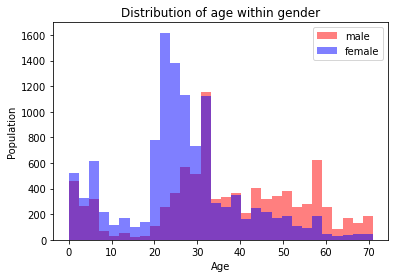

In [0]:
plt.hist(y_age_data[y_gender_data], bins=30, color='red', alpha=0.5, label='male')
plt.hist(y_age_data[~y_gender_data], bins=30, color='blue', alpha=0.5, label='female')
plt.legend()
plt.title('Distribution of age within gender')
plt.xlabel('Age')
plt.ylabel('Population')
plt.show()

# Seems that Dataset / Generator / Detector model may be biased

# Training a linear model for obtaining gender direction in latent space

In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

In [0]:
%%time
# So let's find the gender direction in the latent space

clf = LogisticRegression(class_weight='balanced').fit(X_data, y_gender_data)
gender_direction = clf.coef_.reshape((18, 512))

# So yep, that's all. We made it.
# But let's do some research first. We'll pick that up later on.

CPU times: user 49.1 s, sys: 782 ms, total: 49.8 s
Wall time: 25.6 s


### Evaluating model performance

In [0]:
%%time
clf = SGDClassifier('log', class_weight='balanced') # SGB model for performance sake
scores = cross_val_score(clf, X_data, y_gender_data, scoring='accuracy', cv=5)
clf.fit(X_data, y_gender_data)

print(scores)
print('Mean: ', np.mean(scores))

# Accuracy ? Meh. But gender distribution is almost balanced ... at least for simplicity sake

[0.88084687 0.89980305 0.88623492 0.90076336 0.87269146]
Mean:  0.888067931547592
CPU times: user 5min 20s, sys: 573 ms, total: 5min 20s
Wall time: 5min 20s


#### Dependency of gender detection errors on age 

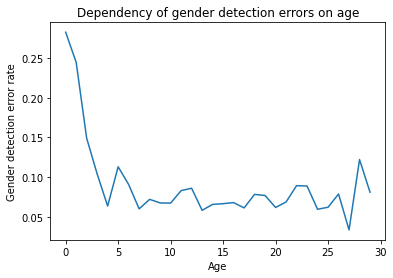

In [0]:
bins, bin_edges = np.histogram(y_age_data, bins=30)
errors,_ = np.histogram(y_age_data[clf.predict(X_data) != y_gender_data], bin_edges)

plt.plot(errors / bins)
plt.title('Dependency of gender detection errors on age')
plt.ylabel('Gender detection error rate')
plt.xlabel('Age')
plt.show()

# Seems that the most diffictul for model is to distinguish babies. For me as well to be honest.
# Or model which we used for creating "ground truth" produces random guesses
# I bet that both are true

#### Dependency of accuracy on training data size

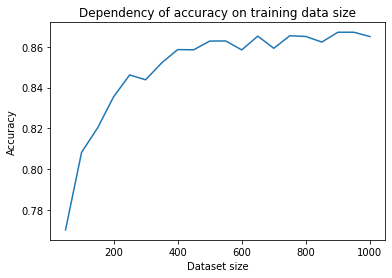

CPU times: user 53.9 s, sys: 10.3 s, total: 1min 4s
Wall time: 50.3 s


In [0]:
%%time

nb_folds = 5
splits = 20
scores = np.zeros((splits, nb_folds))
dataset_size = list()

for fold_id, (train_idx, test_idx) in enumerate(StratifiedKFold(nb_folds, True, 42).split(X_data, y_gender_data)):
    X_train, X_test = X_data[train_idx][:1000], X_data[test_idx]
    y_train, y_test = y_gender_data[train_idx][:1000], y_gender_data[test_idx]
    
    for split_id in range(splits):
        nb_samples = int((len(X_train)/splits) * (split_id+1))
        dataset_size.append(nb_samples)
        clf = SGDClassifier('log', class_weight='balanced').fit(X_train[:nb_samples], y_train[:nb_samples])
        scores[split_id][fold_id] = accuracy_score(y_test, clf.predict(X_test))
        

plt.plot(dataset_size[:splits], scores.mean(axis=1))
plt.title('Dependency of accuracy on training data size')
plt.xlabel('Dataset size')
plt.ylabel('Accuracy')
plt.show()

# Seems that 100 labeled examples is already enough to reach 80% accuracy (for gender).
# That's an interesting insight.

#### Latent layers importance

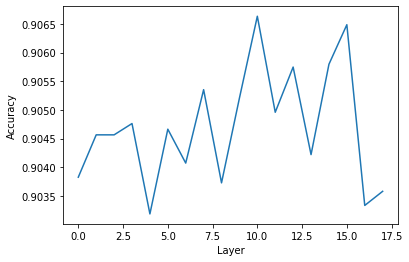

In [0]:
# Let's try to find out which latent layer is most useful for predicting gender

scores = list()
for layer in tqdm_notebook(range(18)):
    clf = SGDClassifier('log', class_weight='balanced')
    scores.append(cross_val_score(clf, X_data.reshape((-1, 18, 512))[:,layer], y_gender_data, scoring='accuracy', cv=5).mean())
    
plt.plot(np.arange(0,18), scores)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.show()

# Huh? Seems that every latent layer contains some information about gender.
# I didn't expect that to be honest.

# Visualization of gender transformation

In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

In [6]:
%%time
# Do you remember gender_direction ? 
# Anyway let's train it one more time

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_data.reshape((-1, 18*512)), y_gender_data)
gender_direction = clf.coef_.reshape((18, 512))

CPU times: user 1min 5s, sys: 1.3 s, total: 1min 6s
Wall time: 34.8 s


In [7]:
%%time

clf = LogisticRegression()
clf.fit(X_data.reshape((-1, 18*512)), y_happiness_data)
happiness_direction = clf.coef_.reshape((18, 512))

CPU times: user 1min 4s, sys: 1.08 s, total: 1min 5s
Wall time: 33.9 s


In [8]:
%%time

clf = LogisticRegression()
clf.fit(X_data.reshape((-1, 18*512)), y_glasses_data)
glasses_direction = clf.coef_.reshape((18, 512))

CPU times: user 1min 5s, sys: 970 ms, total: 1min 6s
Wall time: 34.2 s


In [9]:
# gender_dircetion.shape
y_glasses_data.shape

(20307,)

In [0]:
import PIL.Image
import dnnlib.tflib as tflib
from encoder.generator_model import Generator
import tensorflow as tf

URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [0]:
import copy

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

tag_directions = {
    'gender': gender_direction,
    'happiness': happiness_direction,
    'glasses': glasses_direction
}

dlatents_gen = X_data.reshape((-1, 18, 512))[0]

def truncate(dlatents, truncation_psi, maxlayer = 8):
    dlatent_avg = tf.get_default_session().run(Gs.own_vars["dlatent_avg"])
    layer_idx = np.arange(16)[np.newaxis, :, np.newaxis]
    ones = np.ones(layer_idx.shape, dtype=np.float32)
    coefs = tf.where(layer_idx < maxlayer, truncation_psi * ones, ones)
    return tf.get_default_session().run(tflib.lerp(dlatent_avg, dlatents, coefs))

def modify_and_sample(psi, truncate_pre, truncate_post, **kwargs):
    if truncate_pre == True:
        dlatents_mod = truncate(copy.deepcopy(dlatents_gen), psi)
    else:
        dlatents_mod = copy.deepcopy(dlatents_gen)
    
    for tag in kwargs:
        dlatents_mod += tag_directions[tag] * kwargs[tag]

    display_psi = None
    if truncate_post == True:
        display_psi = psi
    
    return generate_image(dlatents_mod)

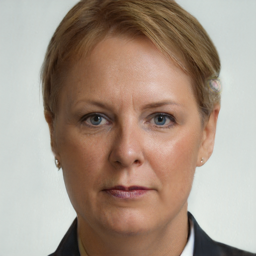

In [20]:
import PIL.Image

gen_img = modify_and_sample(0.5, False, False, gender=-4.0, happiness=-1.5, glasses=0)
gen_img

In [13]:
# For generating these face untruncated sampling was used

for i in range(10):
    move_and_show(X_data.reshape((-1, 18, 512))[i], happiness_direction, [-5, -1.5, 0, 1.5, 5])

Output hidden; open in https://colab.research.google.com to view.

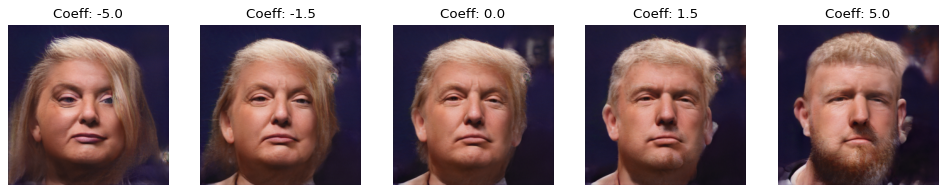

In [0]:
donald_trump = np.load('ffhq_dataset/latent_representations/donald_trump_01.npy')
move_and_show(donald_trump, gender_dircetion, [-5, -1.5, 0, 1.5, 5])

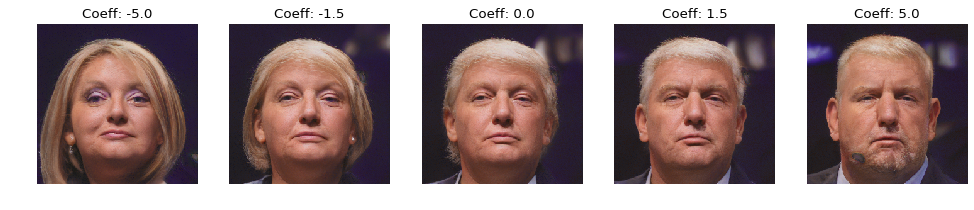

In [0]:
#
# Better approach for learning better representations is coming...some regularization magic is happening
#
# donald_trump = np.load('dark/deep/fantasy')
# move_and_show(donald_trump, gender_dircetion, [-5, -1.5, 0, 1.5, 5])

# - here is some images -

# Try to use some non-linear model

Maybe we can do better if we train some non-linear model ?
But how we can move our latent vetors in non-linear space ? 
So let's see

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_data.reshape((-1, 18*512)), y_gender_data, validation_split=0.2, epochs=5)
model = Model(model.input, model.layers[-2].output)

# works bit better, but in general accuracy is quite similar to the linear model

W0219 00:50:03.422899 139626807379712 deprecation.py:506] From /home/dnikitko/miniconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 16245 samples, validate on 4062 samples
Epoch 1/5
16245/16245 [==============================] - 4s 249us/step - loss: 0.2675 - acc: 0.8833 - val_loss: 0.2340 - val_acc: 0.9000
Epoch 2/5
16245/16245 [==============================] - 1s 61us/step - loss: 0.2163 - acc: 0.9048 - val_loss: 0.2095 - val_acc: 0.9087
Epoch 3/5
16245/16245 [==============================] - 1s 61us/step - loss: 0.2002 - acc: 0.9120 - val_loss: 0.2043 - val_acc: 0.9121
Epoch 4/5
16245/16245 [==============================] - 2s 103us/step - loss: 0.1818 - acc: 0.9220 - val_loss: 0.2105 - val_acc: 0.9114
Epoch 5/5
16245/16245 [==============================] - 6s 360us/step - loss: 0.1757 - acc: 0.9243 - val_loss: 0.2033 - val_acc: 0.9165


In [0]:
# some dark magic is happening here

embedding_model = Sequential()
embedding_model.add(Embedding(10, 18*512, input_length=1)) # it's actually just a variable
embedding_model.add(Flatten())

nonliner_gender_model = Model(embedding_model.input, model(embedding_model.output))
nonliner_gender_model.layers[-1].trainable = False # fix non-linear model and train only embeddings
nonliner_gender_model.compile('sgd', 'mse')

nonliner_gender_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])
y_data_real = nonliner_gender_model.predict(np.arange(10))
y_data_real

array([[ 1.2021605e+01],
       [-7.1482496e+00],
       [-4.6383137e-01],
       [-2.9295561e+01],
       [-1.7953129e+00],
       [ 2.5603473e-02],
       [-7.8261650e-01],
       [ 1.0195279e+01],
       [ 4.0958791e+00],
       [-3.0682669e+01]], dtype=float32)

In [0]:
# and here

nonliner_gender_model.fit(np.arange(10), np.full((10, 1), 20), verbose=0, epochs=500)
nonliner_gender_model.predict(np.arange(10))

W0219 00:50:17.978835 139626807379712 deprecation.py:323] From /home/dnikitko/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


array([[19.7661    ],
       [19.48406   ],
       [-0.11429672],
       [-0.11429672],
       [-0.11429672],
       [18.75907   ],
       [20.33419   ],
       [21.558825  ],
       [19.05434   ],
       [-0.11429672]], dtype=float32)

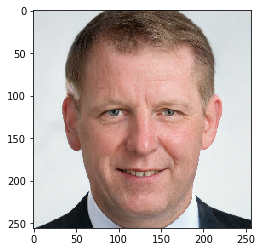

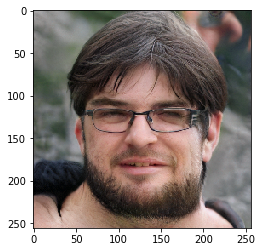

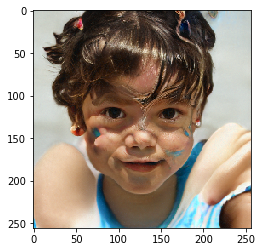

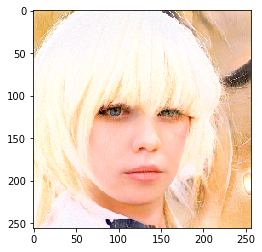

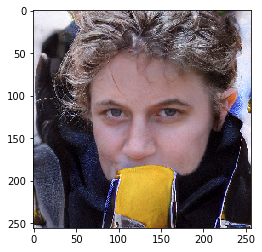

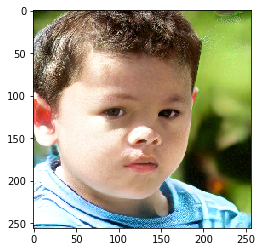

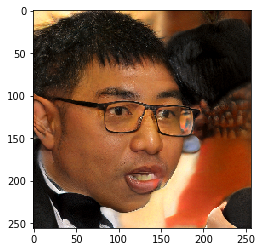

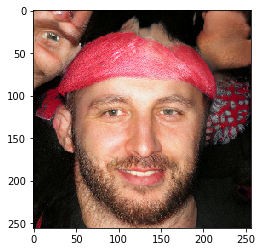

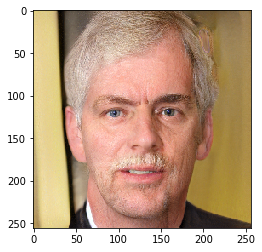

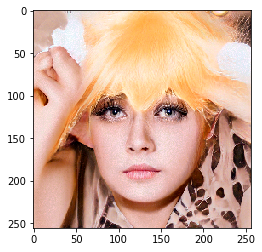

In [0]:
for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()

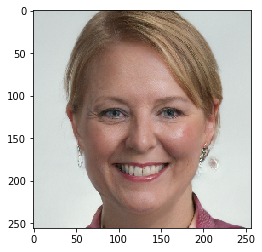

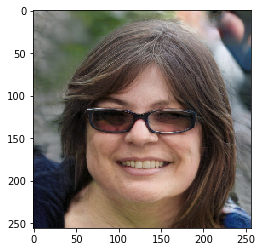

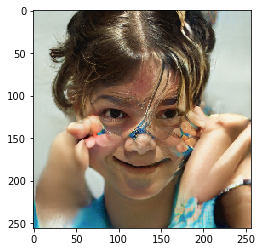

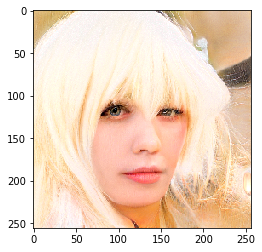

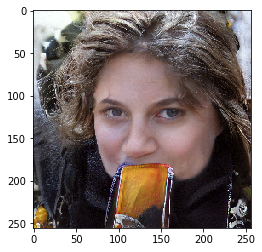

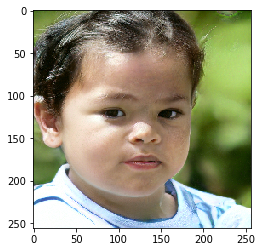

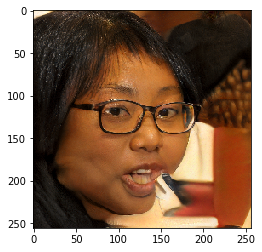

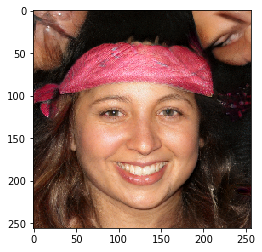

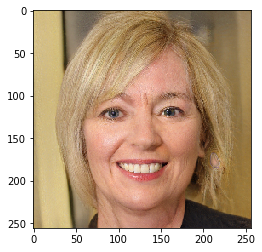

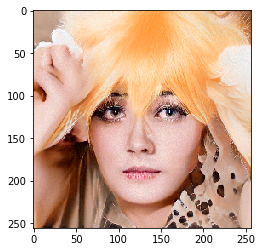

In [0]:
# reset latents and try it over but now in another direction 
nonliner_gender_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])

nonliner_gender_model.fit(np.arange(10), np.full((10, 1), -20), verbose=0, epochs=500)

for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()

In [0]:
# Did you expect that it's gonna work ? :)

# In general:
# 1) Instead of linear model we trained a non-linear model (two layers neural network) for predicting age
# 2) For a given latent vector we want to find a direction in non-linear space to become more male\female
# 3) Direction ? Sounds like we can use gradient descent...
# 4) So that's actually what we do, step by step we optimize latent vector to become more male\female